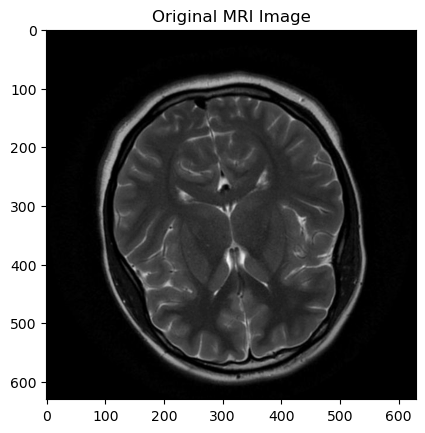

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Loading sample image
image_path = "1 no.jpeg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
plt.imshow(image, cmap='gray')
plt.title('Original MRI Image')
plt.show()

In [40]:
# Resize the image to the size expected by the model (e.g., 128x128)
image_resized = cv2.resize(image, (128, 128))

# Normalize the image (if required by your model)
image_normalized = image_resized / 255.0

# Reshape for the model if necessary
image_input = image_normalized.reshape(1, 128, 128, 1)  # Batch size of 1, and grayscale image

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [42]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

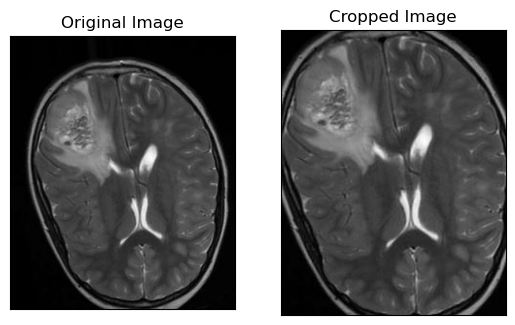

In [43]:
ex_img = cv2.imread('Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [44]:
def load_data(dir_list, image_size):
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [45]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle

def crop_brain_contour(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.show()
    
    return new_image

def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')  # Add more extensions if needed
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            if filename.lower().endswith(valid_extensions):  # Check for valid image file extensions
                file_path = os.path.join(directory, filename)
                image = cv2.imread(file_path)
                if image is not None:
                    image = crop_brain_contour(image, plot=False)
                    image = cv2.resize(image, (image_width, image_height), interpolation=cv2.INTER_CUBIC)
                    image = image / 255.
                    X.append(image)

                    if 'yes' in directory.lower():
                        y.append([1])
                    else:
                        y.append([0])
    
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

augmented_path = 'augmented_data/'

augmented_yes = os.path.join(augmented_path, 'yes')
augmented_no = os.path.join(augmented_path, 'no')

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))


Number of examples is: 1814
X shape is: (1814, 240, 240, 3)
y shape is: (1814, 1)


In [46]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_images(X, y, n=30):
    for label in [0, 1]:
        # Grab the first n images with the corresponding y values equal to label
        indices = np.argwhere(y == label).flatten()  # Get the indices of images with the current label
        n_images = X[indices][:n]  # Slice the images based on these indices

        columns_n = 10  # Number of columns for plotting
        rows_n = int(np.ceil(n / columns_n))  # Adjust rows to ensure all images fit

        plt.figure(figsize=(20, 10))

        for i, image in enumerate(n_images):
            plt.subplot(rows_n, columns_n, i + 1)
            plt.imshow(image)
            
            # Remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        # Correct label to string conversion
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

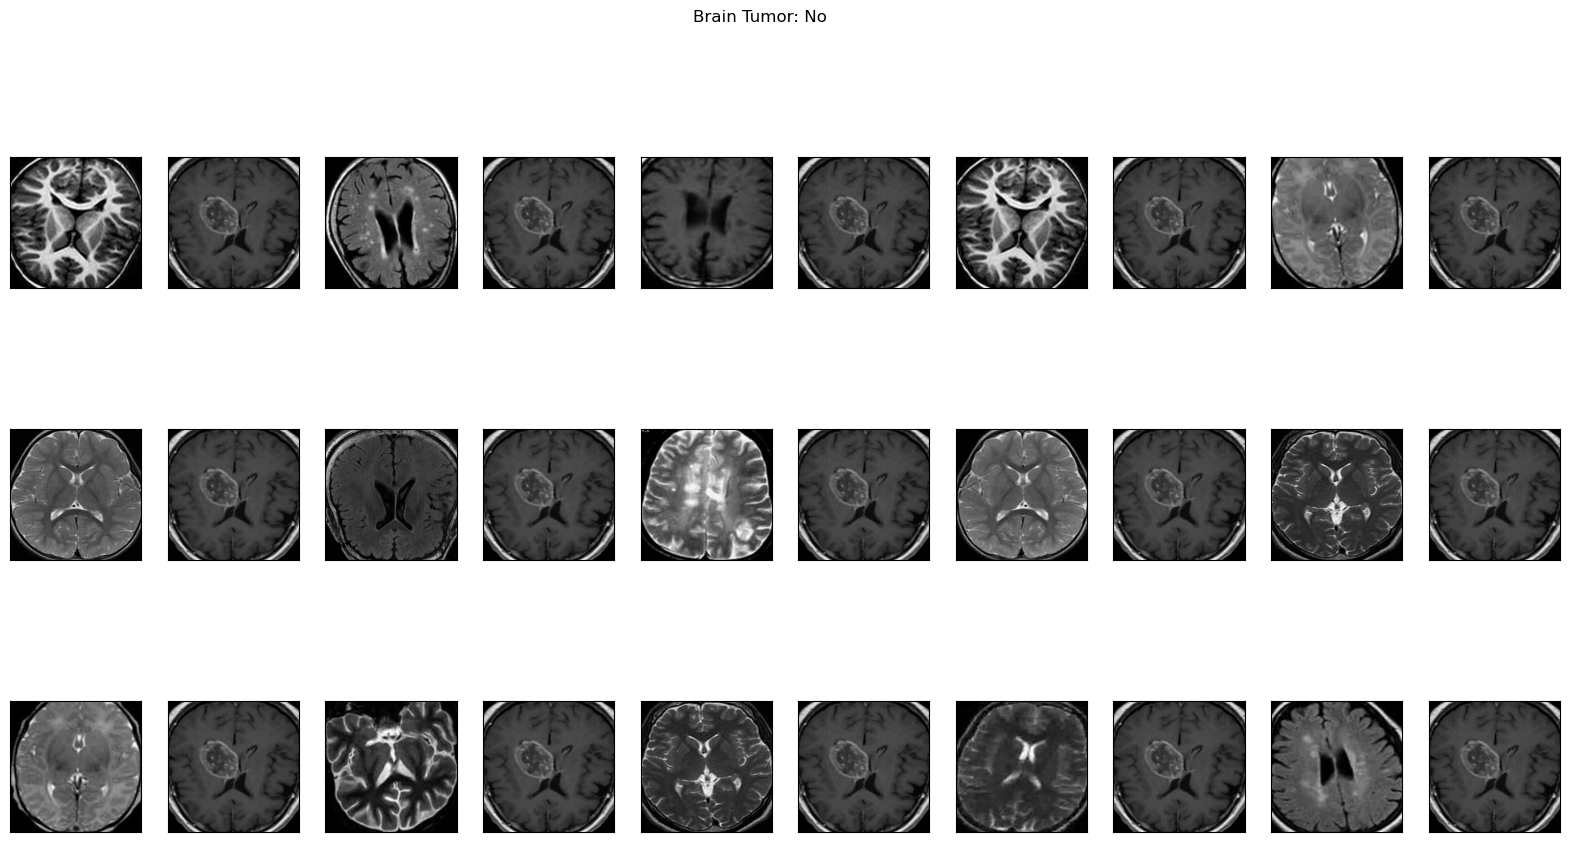

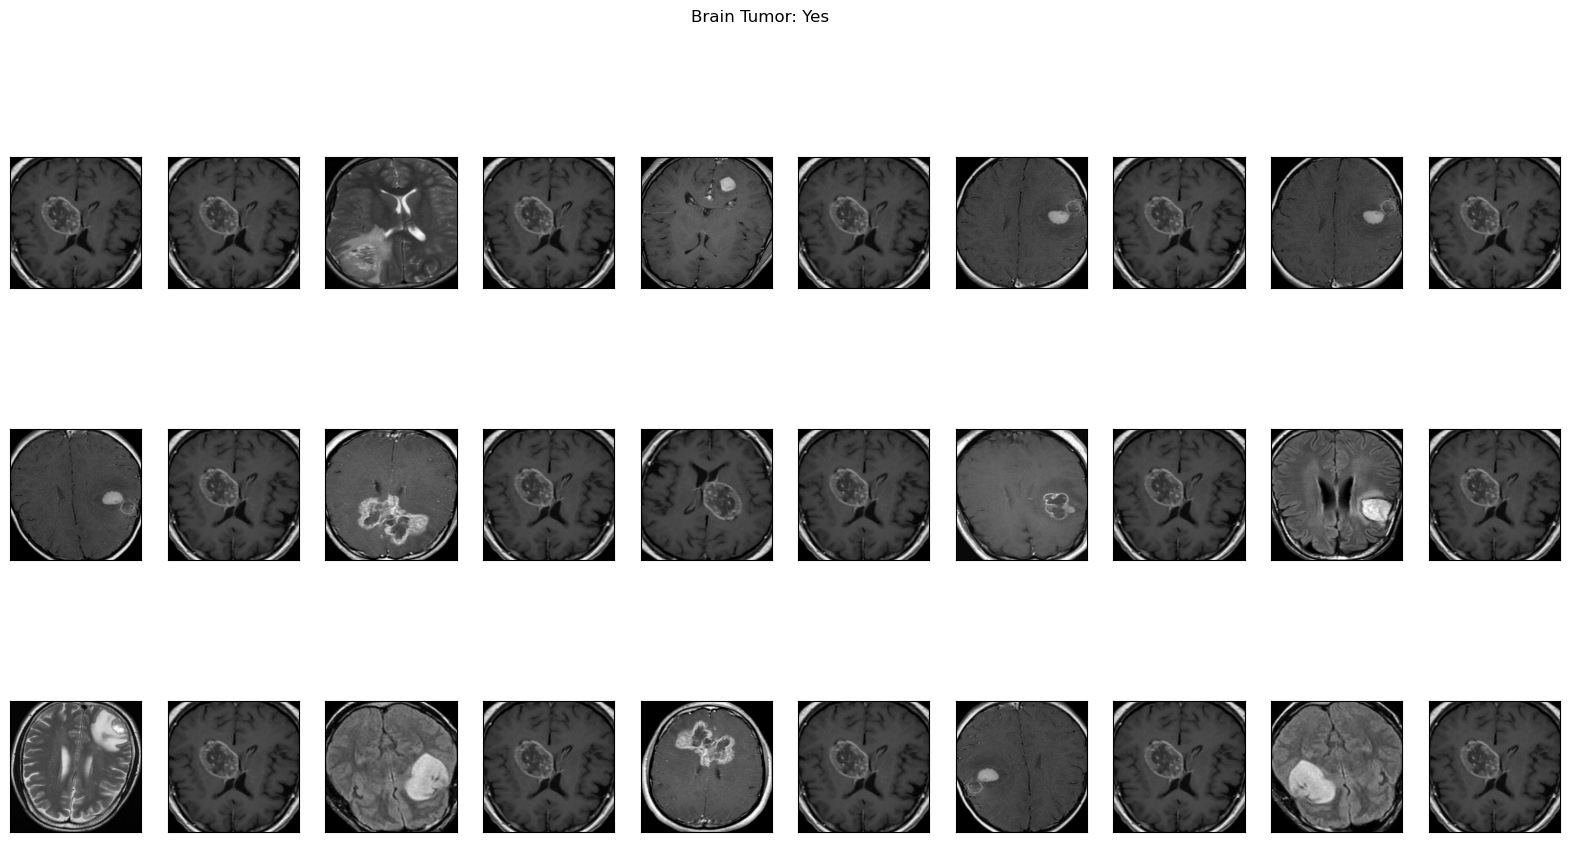

In [47]:
plot_sample_images(X, y)


In [48]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [49]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [50]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1269
number of development examples = 273
number of test examples = 272
X_train shape: (1269, 240, 240, 3)
Y_train shape: (1269, 1)
X_val (dev) shape: (273, 240, 240, 3)
Y_val (dev) shape: (273, 1)
X_test shape: (272, 240, 240, 3)
Y_test shape: (272, 1)


In [51]:
 # Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [52]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [53]:
def build_model(input_shape):
    """
    Arguments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape
    X_input = Input(input_shape)  # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input)  # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)  # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X)  # shape=(?, 59, 59, 32) 
    
    # Adding another convolutional layer to improve feature extraction
    X = Conv2D(64, (3, 3), strides=(1, 1), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X)  # shape=(?, 57, 57, 64)
    
    # Additional MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X)  # shape=(?, 14, 14, 64)
    
    # FLATTEN X 
    X = Flatten()(X)  # shape=(?, 12544)
    
    # FULLYCONNECTED
    X = Dense(128, activation='relu', name='fc1')(X)  # Adding a dense layer for better learning
    X = Dense(1, activation='sigmoid', name='fc2')(X)  # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='BrainDetectionModel')
    
    return model


In [54]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [55]:
model = build_model(IMG_SHAPE)

In [57]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 57, 57, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 57, 57, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,505 (6.22 MB)

 Trainable params: 1,629,313 (6.22 MB)

 Non-trainable params: 192 (768.00 B)

In [58]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import time

# Define the directory where you want to save your models
model_dir = "augmented_data/models/"

# Create the filepath string with the updated directory path and `.keras` extension
filepath = model_dir + "cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"

# Define the ModelCheckpoint callback with the new directory path and `.keras` extension
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Assuming `tensorboard` is already defined as a TensorBoard callback
# e.g., tensorboard = TensorBoard(log_dir='logs')

# Record the start time
start_time = time.time()

# Fit the model
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

# Record the end time and calculate execution time
end_time = time.time()
execution_time = (end_time - start_time)

# Define a function to format the execution time into a human-readable string
def hms_string(seconds):
    h = int(seconds // 3600)
    m = int((seconds % 3600) // 60)
    s = int(seconds % 60)
    return f"{h}h {m}m {s}s"

# Print the elapsed time
print(f"Elapsed time: {hms_string(execution_time)}")



Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.7187 - loss: 3.4852
Epoch 1: val_accuracy improved from -inf to 0.21978, saving model to augmented_data/models/cnn-parameters-improvement-01-0.22.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7211 - loss: 3.4347 - val_accuracy: 0.2198 - val_loss: 0.9862
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9290 - loss: 0.1789
Epoch 2: val_accuracy improved from 0.21978 to 0.80952, saving model to augmented_data/models/cnn-parameters-improvement-02-0.81.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9291 - loss: 0.1784 - val_accuracy: 0.8095 - val_loss: 0.5042
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.9698 - loss: 0.1047
Epoch 3: val_accuracy did not improve from 0.80952
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9696 - loss: 0.1048 - val_accuracy: 0.7949 - val_loss: 0.9509
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.9842 - loss: 0.0

In [61]:
# Record the start time
start_time = time.time()

# Fit the model
model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

# Record the end time and calculate execution time
end_time = time.time()
execution_time = (end_time - start_time)

# Print the elapsed time
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9995 - loss: 0.0054
Epoch 1: val_accuracy improved from 0.96703 to 0.97436, saving model to augmented_data/models/cnn-parameters-improvement-01-0.97.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9995 - loss: 0.0054 - val_accuracy: 0.9744 - val_loss: 0.0905
Epoch 2/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0032
Epoch 2: val_accuracy improved from 0.97436 to 0.98535, saving model to augmented_data/models/cnn-parameters-improvement-02-0.99.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9853 - val_loss: 0.0683
Epoch 3/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0022
Epoch 3: val_accuracy improved from 0.98535 to 0.98901, saving model to augmented_data/models/cnn-parameters-improvement-03-0.99.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9890 - val_loss: 0.0442
Elap

In [62]:
# Record the start time
start_time = time.time()

# Fit the model
model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

# Record the end time and calculate execution time
end_time = time.time()
execution_time = (end_time - start_time)

# Print the elapsed time
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0025
Epoch 1: val_accuracy did not improve from 0.98901
40/40 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9890 - val_loss: 0.0166
Epoch 2/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0014
Epoch 2: val_accuracy improved from 0.98901 to 1.00000, saving model to augmented_data/models/cnn-parameters-improvement-02-1.00.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 3/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0019
Epoch 3: val_accuracy did not improve from 1.00000
40/40 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9927 - val_loss: 0.0107
Elapsed time: 0h 2m 12s


In [63]:
history = model.history.history

In [64]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


#Plot Loss & Accuracy

In [65]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

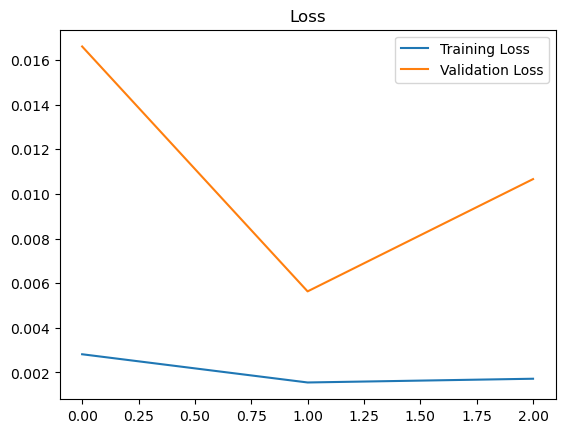

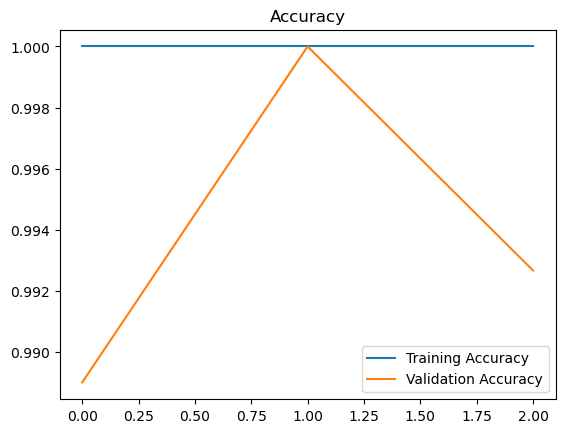

In [66]:
plot_metrics(history) 

## Loading the best model

In [67]:
best_model = load_model(filepath='augmented_data/models/cnn-parameters-improvement-06-0.63.keras')

In [68]:
best_model.metrics_names

['loss', 'compile_metrics']

## Evaluating the best model on the testing data:

In [69]:
loss, accuracy = best_model.evaluate(x=X_test, y=y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.7333 - loss: 0.5917


## Accuracy of the best model on the testing data:

In [70]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.5735647678375244
Test Accuracy = 0.7647058963775635


## F1 score for the best model on the testing data:

In [71]:
# Predict probabilities for the test data
y_test_prob = best_model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step


In [72]:
# Compute the F1 score
f1score = compute_f1_score(y_test, y_test_prob)

# Print the F1 score
print(f"F1 score: {f1score}")

F1 score: 0.8511627906976744


## Let's also find the f1 score on the validation data:

In [73]:
y_val_prob = best_model.predict(X_val)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


In [74]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8697674418604652


## Results Interpretation

## Let's print the percentage of positive and negative examples:

In [75]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")
    
# the whole data
data_percentage(y)

Number of examples: 1814
Percentage of positive examples: 79.05181918412349%, number of pos examples: 1434
Percentage of negative examples: 20.948180815876515%, number of neg examples: 380


In [76]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1269
Percentage of positive examples: 78.32939322301024%, number of pos examples: 994
Percentage of negative examples: 21.670606776989757%, number of neg examples: 275
Validation Data:
Number of examples: 273
Percentage of positive examples: 79.48717948717949%, number of pos examples: 217
Percentage of negative examples: 20.512820512820515%, number of neg examples: 56
Testing Data:
Number of examples: 272
Percentage of positive examples: 81.98529411764706%, number of pos examples: 223
Percentage of negative examples: 18.014705882352942%, number of neg examples: 49


## As expectred, the percentage of positive examples are above 80%.

## Conclusion:
### Now, the model detects brain tumor with:
### 81% accuracy on the test set.
### 0.85 F1 score on the test set.
### These resutls are very good considering that the data is balanced.

## Hooray!